# Model selection throuh Optuna


In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
from matplotlib.gridspec import GridSpec
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PowerTransformer
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR

from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsRegressor
import warnings
from sklearn.exceptions import DataConversionWarning
import mlflow

warnings.filterwarnings("ignore")

# importlib.reload(data_clean_script)     # reload

In [21]:
# !pip install optuna
# !pip install xgboost
# !pip install lightgbm

from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
import optuna

In [22]:
import dagshub

dagshub.init(repo_owner="rabin20-04", repo_name="delivery_time_prediction", mlflow=True)

Accessing as rabin20-04

Initialized MLflow to track repo "rabin20-04/delivery_time_prediction"

Repository rabin20-04/delivery_time_prediction initialized!

In [23]:
from sklearn import set_config

set_config(transform_output="pandas")

#### Data


In [24]:
original_df = pd.read_csv("../data/raw/train.csv")

import sys
import importlib

sys.path.append("../data/files_/")
import data_clean_script

# importlib.reload(data_clean_script)

In [25]:
df = data_clean_script.perform_data_cleaning(original_df)

In [26]:
df.shape

(45502, 16)

In [27]:
df.sample(6)

,age,ratings,weather,traffic,vehicle_condition,type_of_order,type_of_vehicle,multiple_deliveries,festival,city_type,time_taken,is_weekend,pickup_time_minutes,order_time_of_day,distance,distance_type
29212,22.0,4.7,stormy,medium,0,snack,motorcycle,1.0,no,urban,21,0,10.0,evening,NaN,NaN
26389,29.0,4.7,sandstorms,medium,1,meal,scooter,1.0,no,metropolitian,19,0,5.0,evening,13.830780,long
35425,25.0,5.0,windy,low,2,drinks,electric_scooter,1.0,no,urban,16,0,5.0,morning,2.984414,short
14064,21.0,4.7,sunny,medium,2,snack,scooter,0.0,no,metropolitian,13,1,5.0,afternoon,NaN,NaN
34562,NaN,NaN,sandstorms,low,1,meal,motorcycle,1.0,no,urban,21,0,NaN,NaN,1.554477,short
456,20.0,4.6,stormy,low,1,drinks,motorcycle,0.0,no,urban,11,0,10.0,morning,3.116254,short


In [28]:
df.columns.tolist()

['age',
 'ratings',
 'weather',
 'traffic',
 'vehicle_condition',
 'type_of_order',
 'type_of_vehicle',
 'multiple_deliveries',
 'festival',
 'city_type',
 'time_taken',
 'is_weekend',
 'pickup_time_minutes',
 'order_time_of_day',
 'distance',
 'distance_type']

In [29]:
# df.drop(
#     columns={"city_name", "order_day_of_week", "order_month"}, axis=1, inplace=True
# )  # contains just two months data -- may lead to overfit

In [30]:
df.shape

(45502, 16)

In [31]:
df.isna().sum()

age                    1854
ratings                1908
weather                 525
traffic                 510
vehicle_condition         0
type_of_order             0
type_of_vehicle           0
multiple_deliveries     993
festival                228
city_type              1198
time_taken                0
is_weekend                0
pickup_time_minutes    1640
order_time_of_day      2070
distance               3630
distance_type          3630
dtype: int64

In [32]:
num_cols = ["age", "ratings", "pickup_time_minutes", "distance"]
# continuous | categorical | nominal

nominal_cat_cols = [
    "weather",
    "type_of_order",
    "type_of_vehicle",
    "festival",
    "city_type",
    "order_time_of_day",
    "is_weekend",
]
ordinal_cat_cols = ["traffic", "distance_type"]
traffic_order = ["low", "medium", "high", "jam"]
distance_order = ["short", "medium", "long", "very_long"]

In [33]:
df.duplicated().sum()

np.int64(0)

In [34]:
mlflow.set_tracking_uri(
    "https://dagshub.com/rabin20-04/delivery_time_prediction.mlflow"
)

In [35]:
mlflow.set_experiment("EXP-4  Best Model selction - Optuna ")

<Experiment: artifact_location='mlflow-artifacts:/86c6ed12efbd42a98e3524eea46fe207', creation_time=1751270667734, experiment_id='2', last_update_time=1751270667734, lifecycle_stage='active', name='EXP-4  Best Model selction - Optuna ', tags={}>

# Drop missing


<Axes: >

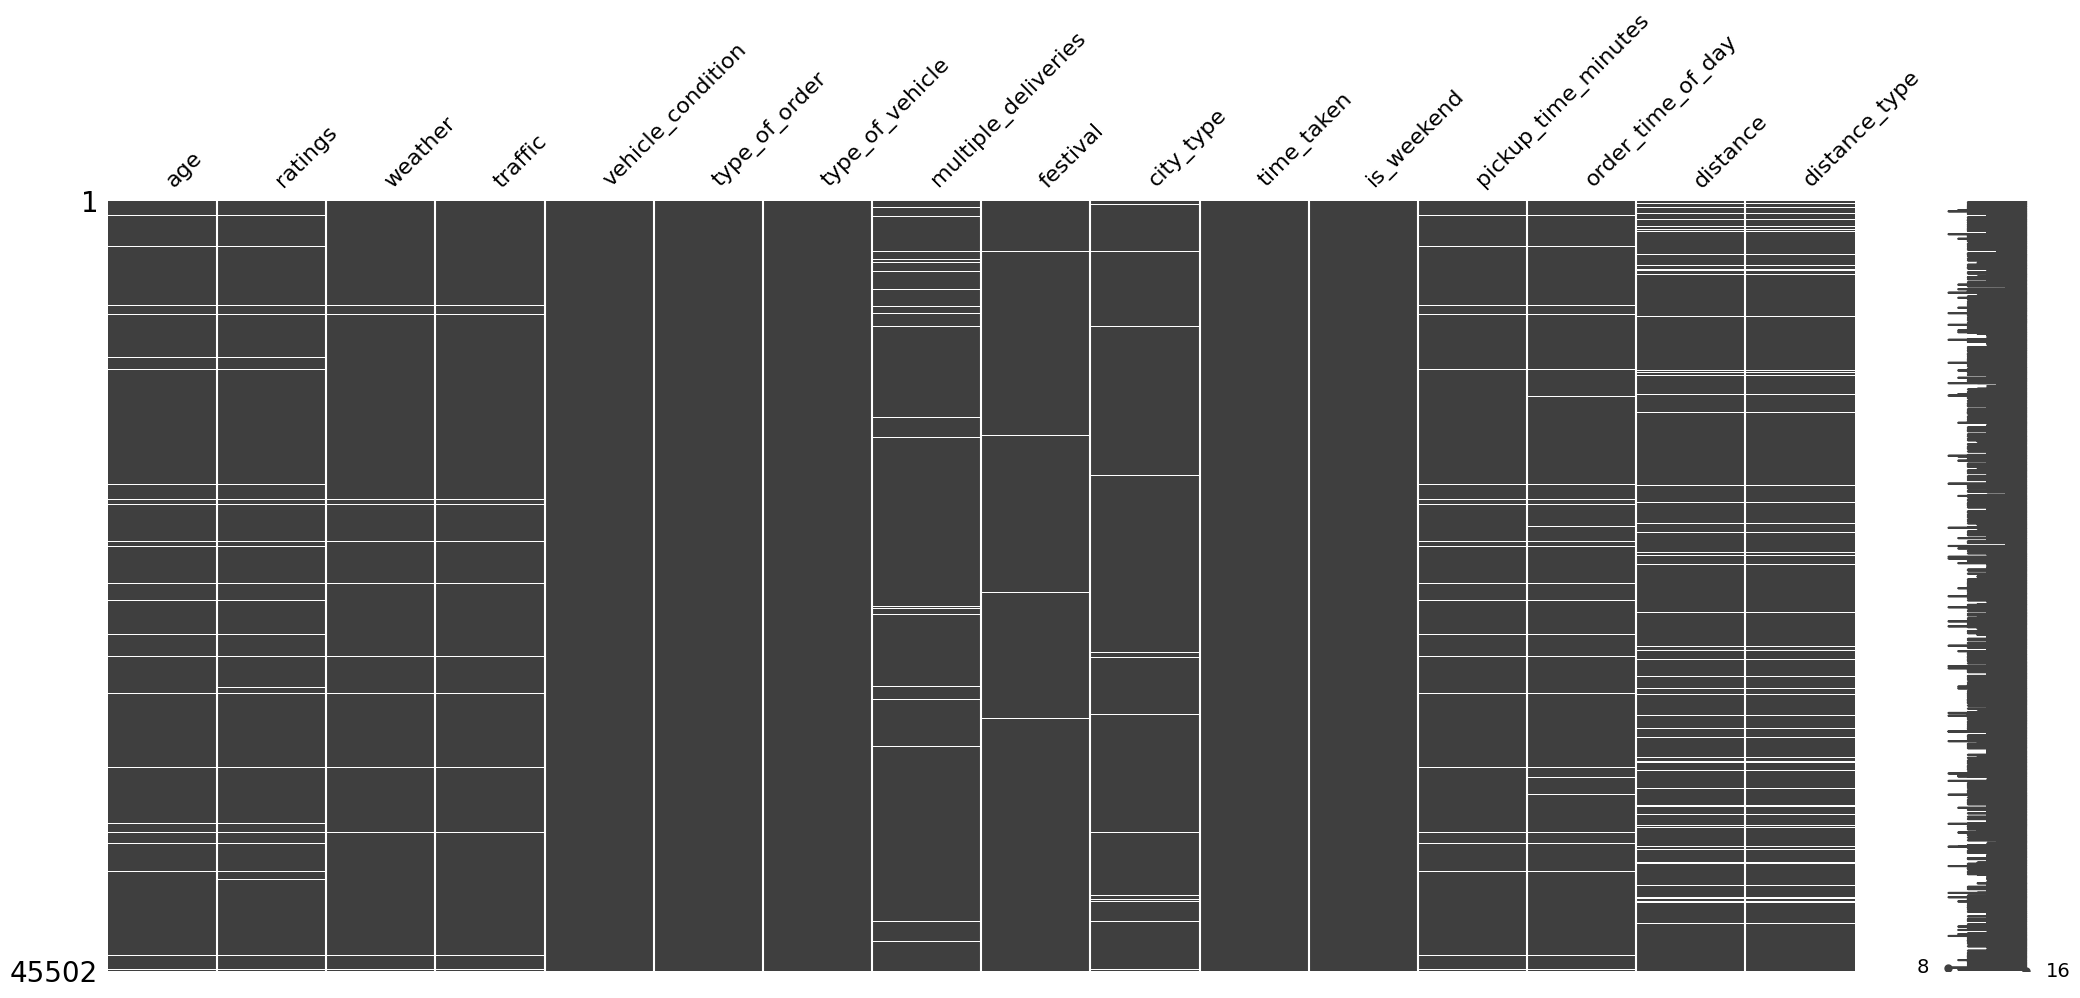

In [36]:
msno.matrix(df)

In [37]:
# Mnar

In [38]:
import mlflow

In [39]:
temp_df = df.copy().dropna()
df.shape, temp_df.shape
temp_df.to_csv("null_droped.csv")

In [40]:
X = temp_df.drop(columns="time_taken", axis=1)
y = temp_df["time_taken"]

In [41]:
xtrain, xtest, ytrain, ytest = train_test_split(X, y, test_size=0.2, random_state=42)

In [42]:
xtrain.shape, xtest.shape, ytrain.shape, ytest.shape,

((30156, 15), (7539, 15), (30156,), (7539,))

In [43]:
xtrain.info()

<class 'pandas.core.frame.DataFrame'>
Index: 30156 entries, 8720 to 19002
Data columns (total 15 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   age                  30156 non-null  float64 
 1   ratings              30156 non-null  float64 
 2   weather              30156 non-null  object  
 3   traffic              30156 non-null  object  
 4   vehicle_condition    30156 non-null  int64   
 5   type_of_order        30156 non-null  object  
 6   type_of_vehicle      30156 non-null  object  
 7   multiple_deliveries  30156 non-null  float64 
 8   festival             30156 non-null  object  
 9   city_type            30156 non-null  object  
 10  is_weekend           30156 non-null  int64   
 11  pickup_time_minutes  30156 non-null  float64 
 12  order_time_of_day    30156 non-null  category
 13  distance             30156 non-null  float64 
 14  distance_type        30156 non-null  category
dtypes: category(2), float

## Preprocessing


In [44]:
preprocessor = ColumnTransformer(
    transformers=[
        ("scale", MinMaxScaler(), num_cols),
        (
            "nominal_encode",
            OneHotEncoder(drop="first", handle_unknown="ignore", sparse_output=False),
            nominal_cat_cols,
        ),
        (
            "ordinal_encode",
            OrdinalEncoder(categories=[traffic_order, distance_order]),
            ordinal_cat_cols,
        ),
    ],
    remainder="passthrough",
    n_jobs=3,
    verbose_feature_names_out=False,
)
preprocessor.set_output(transform="pandas")

,transformers,"[('scale', ...), ('nominal_encode', ...), ...]"
,remainder,'passthrough'
,sparse_threshold,0.3
,n_jobs,3
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,False
,force_int_remainder_cols,'deprecated'
,feature_range,"(0, ...)"
,copy,True
,clip,False


In [45]:
X_train_trans = preprocessor.fit_transform(xtrain)
X_test_trans = preprocessor.transform(xtest)
pt = PowerTransformer()
y_train_pt = pt.fit_transform(ytrain.values.reshape(-1, 1))
y_test_pt = pt.transform(ytest.values.reshape(-1, 1))

In [46]:
X_train_trans.shape

(30156, 25)

In [27]:
X_train_trans.head()

,age,ratings,pickup_time_minutes,distance,weather_fog,weather_sandstorms,weather_stormy,weather_sunny,weather_windy,type_of_order_drinks,...,city_type_semi-urban,city_type_urban,order_time_of_day_evening,order_time_of_day_morning,order_time_of_day_night,is_weekend_1,traffic,distance_type,vehicle_condition,multiple_deliveries
8720,0.473684,0.56,1.0,0.404165,0.0,0.0,0.0,1.0,0.0,1.0,...,1.0,0.0,0.0,0.0,1.0,0.0,3.0,1.0,0,2.0
25245,1.000000,0.76,0.0,0.154044,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0,1.0
34118,0.473684,0.80,0.5,0.002461,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,2.0,0.0,1,0.0
26036,1.000000,0.92,1.0,0.460411,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,2.0,0,1.0
37194,0.526316,0.76,0.5,0.243676,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1,1.0


<Axes: >

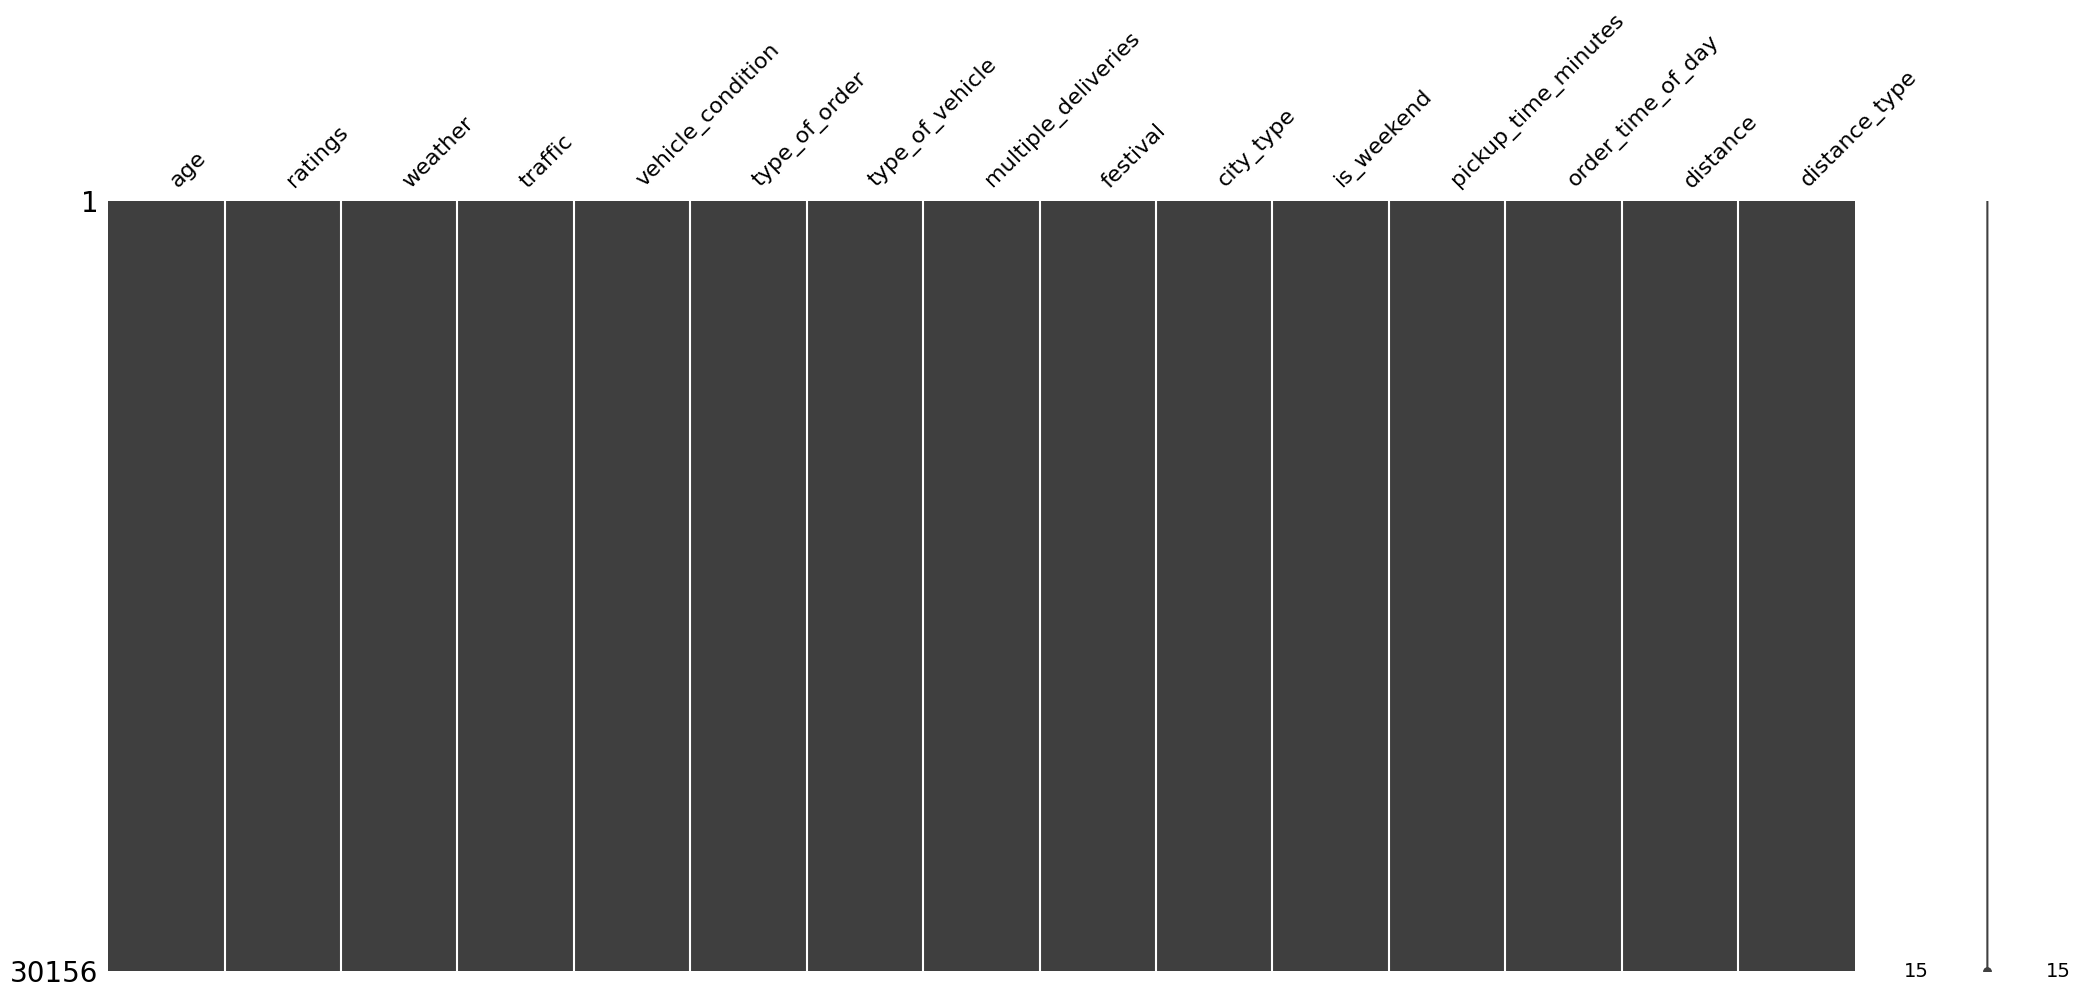

In [28]:
msno.matrix(xtrain)

## Optuna


In [ ]:
def objective(trial):
    with mlflow.start_run(nested=True):
        model_name = trial.suggest_categorical(
            "model", ["SVM", "RF", "KNN", "GB", "XGB", "LGBM"]
        )

        if model_name == "SVM":
            kernel_svm = trial.suggest_categorical(
                "kernel_svm", ["linear", "poly", "rbf"]
            )
            if kernel_svm == "linear":
                c_linear = trial.suggest_float("c_linear", 0, 10)
                model = SVR(C=c_linear, kernel="linear")

            elif kernel_svm == "poly":
                c_poly = trial.suggest_float("c_poly", 0, 10)
                degree_poly = trial.suggest_int("degree_poly", 1, 5)
                model = SVR(C=c_poly, degree=degree_poly, kernel="poly")

            else:
                c_rbf = trial.suggest_float("c_rbf", 0, 100)
                gamma_rbf = trial.suggest_float("gamma_rbf", 0, 10)
                model = SVR(C=c_rbf, gamma=gamma_rbf, kernel="rbf")

        elif model_name == "RF":
            n_estimators_rf = trial.suggest_int("n_estimators_rf", 10, 200)
            max_depth_rf = trial.suggest_int("max_depth_rf", 2, 20)
            model = RandomForestRegressor(
                n_estimators=n_estimators_rf,
                max_depth=max_depth_rf,
                random_state=42,
                n_jobs=4,
            )

        elif model_name == "GB":
            n_estimators_gb = trial.suggest_int("n_estimators_gb", 10, 200)
            learning_rate_gb = trial.suggest_float("learning_rate_gb", 0, 1)
            max_depth_gb = trial.suggest_int("max_depth_gb", 2, 20)
            model = GradientBoostingRegressor(
                n_estimators=n_estimators_gb,
                learning_rate=learning_rate_gb,
                max_depth=max_depth_gb,
                random_state=42,
            )

        elif model_name == "KNN":
            n_neighbors_knn = trial.suggest_int("n_neighbors_knn", 1, 25)
            weights_knn = trial.suggest_categorical(
                "weights_knn", ["uniform", "distance"]
            )
            model = KNeighborsRegressor(
                n_neighbors=n_neighbors_knn, weights=weights_knn, n_jobs=4
            )

        elif model_name == "XGB":
            n_estimators_xgb = trial.suggest_int("n_estimators_xgb", 10, 200)
            learning_rate_xgb = trial.suggest_float("learning_rate_xgb", 0.1, 0.5)
            max_depth_xgb = trial.suggest_int("max_depth_xgb", 2, 20)
            model = XGBRegressor(
                n_estimators=n_estimators_xgb,
                learning_rate=learning_rate_xgb,
                max_depth=max_depth_xgb,
                random_state=42,
                n_jobs=4,
            )

        elif model_name == "LGBM":
            n_estimators_lgbm = trial.suggest_int("n_estimators_lgbm", 10, 200)
            learning_rate_lgbm = trial.suggest_float("learning_rate_lgbm", 0.1, 0.5)
            max_depth_lgbm = trial.suggest_int("max_depth_lgbm", 2, 20)
            model = LGBMRegressor(
                n_estimators=n_estimators_lgbm,
                learning_rate=learning_rate_lgbm,
                max_depth=max_depth_lgbm,
                random_state=42,
            )

        model.fit(X_train_trans, y_train_pt.values.ravel())

        mlflow.log_params(model.get_params())

        y_pred_train = model.predict(X_train_trans)
        y_pred_test = model.predict(X_test_trans)

        y_pred_train_org = pt.inverse_transform(y_pred_train.reshape(-1, 1))
        y_pred_test_org = pt.inverse_transform(y_pred_test.reshape(-1, 1))

        error = mean_absolute_error(ytest, y_pred_test_org)

        mlflow.log_param("model", model_name)

        mlflow.log_metric("MAE", error)

        return error

In [ ]:
study = optuna.create_study(direction="minimize", study_name="model_selection")

with mlflow.start_run(run_name="Best Model") as parent:

    study.optimize(objective, n_trials=30, n_jobs=4, show_progress_bar=True)

    mlflow.log_params(study.best_params)

    mlflow.log_metric("best_score", study.best_value)

[I 2025-06-30 13:54:13,766] A new study created in memory with name: model_selection
  0%|          | 0/30 [00:00<?, ?it/s]

🏃 View run aged-fly-903 at: https://dagshub.com/rabin20-04/delivery_time_prediction.mlflow/#/experiments/2/runs/50adfbe519e543bfa0d385f57ddd4a42
🧪 View experiment at: https://dagshub.com/rabin20-04/delivery_time_prediction.mlflow/#/experiments/2


Best trial: 2. Best value: 4.28628:   3%|▎         | 1/30 [00:15<07:43, 15.99s/it]

[I 2025-06-30 13:54:30,154] Trial 2 finished with value: 4.286282017102171 and parameters: {'model': 'RF', 'n_estimators_rf': 84, 'max_depth_rf': 5}. Best is trial 2 with value: 4.286282017102171.
🏃 View run clean-goat-387 at: https://dagshub.com/rabin20-04/delivery_time_prediction.mlflow/#/experiments/2/runs/40e38fda79e34e46b1aa64407d732e29
🧪 View experiment at: https://dagshub.com/rabin20-04/delivery_time_prediction.mlflow/#/experiments/2
🏃 View run spiffy-fish-462 at: https://dagshub.com/rabin20-04/delivery_time_prediction.mlflow/#/experiments/2/runs/4bef55c30e7c447fb6b9133df1763c5e
🧪 View experiment at: https://dagshub.com/rabin20-04/delivery_time_prediction.mlflow/#/experiments/2
🏃 View run bald-shad-30 at: https://dagshub.com/rabin20-04/delivery_time_prediction.mlflow/#/experiments/2/runs/60b50f14ad724bfb89333ace46c812cc
🧪 View experiment at: https://dagshub.com/rabin20-04/delivery_time_prediction.mlflow/#/experiments/2
[LightGBM] [Info] Auto-choosing row-wise multi-threading, th

Best trial: 3. Best value: 4.23068:   7%|▋         | 2/30 [00:20<04:26,  9.53s/it]

[I 2025-06-30 13:54:35,160] Trial 3 finished with value: 4.2306779791643505 and parameters: {'model': 'KNN', 'n_neighbors_knn': 25, 'weights_knn': 'distance'}. Best is trial 3 with value: 4.2306779791643505.


Best trial: 3. Best value: 4.23068:  10%|█         | 3/30 [00:21<02:31,  5.63s/it]

[I 2025-06-30 13:54:36,141] Trial 1 finished with value: 4.258860214302714 and parameters: {'model': 'KNN', 'n_neighbors_knn': 10, 'weights_knn': 'uniform'}. Best is trial 3 with value: 4.2306779791643505.


Best trial: 0. Best value: 4.18961:  13%|█▎        | 4/30 [00:23<01:39,  3.82s/it]

[I 2025-06-30 13:54:37,202] Trial 0 finished with value: 4.189605690159177 and parameters: {'model': 'KNN', 'n_neighbors_knn': 12, 'weights_knn': 'distance'}. Best is trial 0 with value: 4.189605690159177.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000714 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 352
[LightGBM] [Info] Number of data points in the train set: 30156, number of used features: 25
[LightGBM] [Info] Start training from score -0.000000
🏃 View run unruly-sponge-730 at: https://dagshub.com/rabin20-04/delivery_time_prediction.mlflow/#/experiments/2/runs/56d9fc35840b4e24b8435cc8d02c4abf
🧪 View experiment at: https://dagshub.com/rabin20-04/delivery_time_prediction.mlflow/#/experiments/2


Best trial: 4. Best value: 3.05695:  17%|█▋        | 5/30 [00:46<04:37, 11.08s/it]

[I 2025-06-30 13:55:01,161] Trial 4 finished with value: 3.056945359237533 and parameters: {'model': 'LGBM', 'n_estimators_lgbm': 150, 'learning_rate_lgbm': 0.292331729509466, 'max_depth_lgbm': 13}. Best is trial 4 with value: 3.056945359237533.
🏃 View run stately-shoat-566 at: https://dagshub.com/rabin20-04/delivery_time_prediction.mlflow/#/experiments/2/runs/08c844c2fa81432ba6deaa42afbcec9f
🧪 View experiment at: https://dagshub.com/rabin20-04/delivery_time_prediction.mlflow/#/experiments/2
🏃 View run honorable-steed-441 at: https://dagshub.com/rabin20-04/delivery_time_prediction.mlflow/#/experiments/2/runs/08d4139cd7794b23b42dd0e713197451
🧪 View experiment at: https://dagshub.com/rabin20-04/delivery_time_prediction.mlflow/#/experiments/2


Best trial: 4. Best value: 3.05695:  20%|██        | 6/30 [00:52<03:36,  9.04s/it]

[I 2025-06-30 13:55:06,227] Trial 5 finished with value: 4.200560689946568 and parameters: {'model': 'KNN', 'n_neighbors_knn': 19, 'weights_knn': 'distance'}. Best is trial 4 with value: 3.056945359237533.


Best trial: 6. Best value: 3.02306:  23%|██▎       | 7/30 [00:52<02:26,  6.38s/it]

[I 2025-06-30 13:55:07,132] Trial 6 finished with value: 3.023058555512939 and parameters: {'model': 'LGBM', 'n_estimators_lgbm': 97, 'learning_rate_lgbm': 0.26058323818458823, 'max_depth_lgbm': 11}. Best is trial 6 with value: 3.023058555512939.
🏃 View run smiling-mare-554 at: https://dagshub.com/rabin20-04/delivery_time_prediction.mlflow/#/experiments/2/runs/08bd2c77d3f84574b91ae9376e92e686
🧪 View experiment at: https://dagshub.com/rabin20-04/delivery_time_prediction.mlflow/#/experiments/2


Best trial: 6. Best value: 3.02306:  27%|██▋       | 8/30 [00:56<02:03,  5.63s/it]

[I 2025-06-30 13:55:11,149] Trial 7 finished with value: 3.403124095652425 and parameters: {'model': 'GB', 'n_estimators_gb': 56, 'learning_rate_gb': 0.45645678197054984, 'max_depth_gb': 11}. Best is trial 6 with value: 3.023058555512939.
🏃 View run amazing-shoat-908 at: https://dagshub.com/rabin20-04/delivery_time_prediction.mlflow/#/experiments/2/runs/1af88bbe465b47439decd3d514ad4205
🧪 View experiment at: https://dagshub.com/rabin20-04/delivery_time_prediction.mlflow/#/experiments/2
🏃 View run orderly-frog-545 at: https://dagshub.com/rabin20-04/delivery_time_prediction.mlflow/#/experiments/2/runs/de822956733043b0af05b938ea338973
🧪 View experiment at: https://dagshub.com/rabin20-04/delivery_time_prediction.mlflow/#/experiments/2
🏃 View run mercurial-pug-698 at: https://dagshub.com/rabin20-04/delivery_time_prediction.mlflow/#/experiments/2/runs/c6ab4559427d4027a15d5c1d7cb771dc
🧪 View experiment at: https://dagshub.com/rabin20-04/delivery_time_prediction.mlflow/#/experiments/2


Best trial: 6. Best value: 3.02306:  30%|███       | 9/30 [01:22<04:05, 11.71s/it]

[I 2025-06-30 13:55:36,231] Trial 10 finished with value: 4.2306779791643505 and parameters: {'model': 'KNN', 'n_neighbors_knn': 25, 'weights_knn': 'distance'}. Best is trial 6 with value: 3.023058555512939.


Best trial: 6. Best value: 3.02306:  33%|███▎      | 10/30 [01:22<02:47,  8.38s/it]

[I 2025-06-30 13:55:37,155] Trial 9 finished with value: 3.698873535227836 and parameters: {'model': 'RF', 'n_estimators_rf': 152, 'max_depth_rf': 7}. Best is trial 6 with value: 3.023058555512939.


Best trial: 6. Best value: 3.02306:  37%|███▋      | 11/30 [01:23<01:56,  6.12s/it]

[I 2025-06-30 13:55:38,151] Trial 8 finished with value: 3.4240095232638366 and parameters: {'model': 'GB', 'n_estimators_gb': 190, 'learning_rate_gb': 0.8071324142259276, 'max_depth_gb': 5}. Best is trial 6 with value: 3.023058555512939.
🏃 View run trusting-lark-614 at: https://dagshub.com/rabin20-04/delivery_time_prediction.mlflow/#/experiments/2/runs/698405353e1740f5bebc93589d31db0b
🧪 View experiment at: https://dagshub.com/rabin20-04/delivery_time_prediction.mlflow/#/experiments/2
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000668 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 352
[LightGBM] [Info] Number of data points in the train set: 30156, number of used features: 25
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000774 seconds.


Best trial: 6. Best value: 3.02306:  40%|████      | 12/30 [01:28<01:43,  5.78s/it]

[I 2025-06-30 13:55:43,141] Trial 11 finished with value: 3.1107129400470734 and parameters: {'model': 'RF', 'n_estimators_rf': 24, 'max_depth_rf': 19}. Best is trial 6 with value: 3.023058555512939.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000782 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 352
[LightGBM] [Info] Number of data points in the train set: 30156, number of used features: 25
[LightGBM] [Info] Start training from score -0.000000
🏃 View run bouncy-lark-718 at: https://dagshub.com/rabin20-04/delivery_time_prediction.mlflow/#/experiments/2/runs/b798c1abc3974fdb992e0753e479dce4
🧪 View experiment at: https://dagshub.com/rabin20-04/delivery_time_prediction.mlflow/#/experiments/2
🏃 View run defiant-deer-928 at: https://dagshub.com/rabin20-04/delivery_time_prediction.mlflow/#/experiments/2/runs/fc1eec6a20754dbcb6342261a6cd5

Best trial: 6. Best value: 3.02306:  43%|████▎     | 13/30 [01:53<03:17, 11.60s/it]

[I 2025-06-30 13:56:08,129] Trial 12 finished with value: 3.062540068281298 and parameters: {'model': 'LGBM', 'n_estimators_lgbm': 127, 'learning_rate_lgbm': 0.2568397730070846, 'max_depth_lgbm': 12}. Best is trial 6 with value: 3.023058555512939.


Best trial: 6. Best value: 3.02306:  47%|████▋     | 14/30 [01:55<02:14,  8.42s/it]

[I 2025-06-30 13:56:09,203] Trial 13 finished with value: 3.0473223104386435 and parameters: {'model': 'LGBM', 'n_estimators_lgbm': 128, 'learning_rate_lgbm': 0.2678077826477797, 'max_depth_lgbm': 12}. Best is trial 6 with value: 3.023058555512939.


Best trial: 6. Best value: 3.02306:  50%|█████     | 15/30 [01:56<01:36,  6.41s/it]

[I 2025-06-30 13:56:10,945] Trial 14 finished with value: 3.0540433531545466 and parameters: {'model': 'LGBM', 'n_estimators_lgbm': 130, 'learning_rate_lgbm': 0.2752925112839568, 'max_depth_lgbm': 12}. Best is trial 6 with value: 3.023058555512939.
🏃 View run fearless-swan-275 at: https://dagshub.com/rabin20-04/delivery_time_prediction.mlflow/#/experiments/2/runs/8ca972cc3a4b4d04b7d83678c37894c5
🧪 View experiment at: https://dagshub.com/rabin20-04/delivery_time_prediction.mlflow/#/experiments/2


Best trial: 6. Best value: 3.02306:  53%|█████▎    | 16/30 [02:00<01:20,  5.74s/it]

[I 2025-06-30 13:56:15,142] Trial 15 finished with value: 3.0554490471734774 and parameters: {'model': 'LGBM', 'n_estimators_lgbm': 131, 'learning_rate_lgbm': 0.2974420334426772, 'max_depth_lgbm': 12}. Best is trial 6 with value: 3.023058555512939.
🏃 View run awesome-bear-248 at: https://dagshub.com/rabin20-04/delivery_time_prediction.mlflow/#/experiments/2/runs/05bcb46b5b104322a78675347471acac
🧪 View experiment at: https://dagshub.com/rabin20-04/delivery_time_prediction.mlflow/#/experiments/2
🏃 View run delightful-rook-25 at: https://dagshub.com/rabin20-04/delivery_time_prediction.mlflow/#/experiments/2/runs/75318259bdb348b189f20250bdfd4e60
🧪 View experiment at: https://dagshub.com/rabin20-04/delivery_time_prediction.mlflow/#/experiments/2


Best trial: 6. Best value: 3.02306:  57%|█████▋    | 17/30 [02:15<01:47,  8.23s/it]

[I 2025-06-30 13:56:29,171] Trial 16 finished with value: 3.1488215923309326 and parameters: {'model': 'XGB', 'n_estimators_xgb': 131, 'learning_rate_xgb': 0.4427427467961491, 'max_depth_xgb': 4}. Best is trial 6 with value: 3.023058555512939.


Best trial: 6. Best value: 3.02306:  60%|██████    | 18/30 [02:16<01:12,  6.07s/it]

[I 2025-06-30 13:56:30,214] Trial 18 finished with value: 3.364619016647339 and parameters: {'model': 'XGB', 'n_estimators_xgb': 40, 'learning_rate_xgb': 0.2052927567393508, 'max_depth_xgb': 20}. Best is trial 6 with value: 3.023058555512939.
🏃 View run blushing-swan-340 at: https://dagshub.com/rabin20-04/delivery_time_prediction.mlflow/#/experiments/2/runs/ab3955a6f54141528ee25952d099bd61
🧪 View experiment at: https://dagshub.com/rabin20-04/delivery_time_prediction.mlflow/#/experiments/2


Best trial: 6. Best value: 3.02306:  63%|██████▎   | 19/30 [03:08<03:39, 19.98s/it]

[I 2025-06-30 13:57:22,587] Trial 21 finished with value: 4.675437036554555 and parameters: {'model': 'SVM', 'kernel_svm': 'linear', 'c_linear': 1.3629911421230165}. Best is trial 6 with value: 3.023058555512939.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001346 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 352
[LightGBM] [Info] Number of data points in the train set: 30156, number of used features: 25
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Light

Best trial: 6. Best value: 3.02306:  67%|██████▋   | 20/30 [03:11<02:29, 14.97s/it]

[I 2025-06-30 13:57:25,900] Trial 22 finished with value: 3.421006738675118 and parameters: {'model': 'LGBM', 'n_estimators_lgbm': 44, 'learning_rate_lgbm': 0.4797645265706431, 'max_depth_lgbm': 3}. Best is trial 6 with value: 3.023058555512939.


In [1]:
study.best_params


# {'model': 'LGBM',
#  'n_estimators_lgbm': 146,
#  'learning_rate_lgbm': 0.11236909502880069,
#  'max_depth_lgbm': 10}
# {'model': 'GB',
#  'n_estimators_gb': 121,
#  'learning_rate_gb': 0.0510257391863774,
#  'max_depth_gb': 9}

NameError: name 'study' is not defined

In [38]:
# train the model on best parameters

lgbm_params = study.best_params
lgbm = LGBMRegressor(**lgbm_params)

lgbm.fit(X_train_trans, y_train_pt.values.ravel())

[LightGBM] [Warning] Unknown parameter: n_estimators_gb
[LightGBM] [Warning] Unknown parameter: learning_rate_gb
[LightGBM] [Warning] Unknown parameter: max_depth_gb
[LightGBM] [Warning] Unknown parameter: model
[LightGBM] [Warning] Unknown parameter: n_estimators_gb
[LightGBM] [Warning] Unknown parameter: learning_rate_gb
[LightGBM] [Warning] Unknown parameter: max_depth_gb
[LightGBM] [Warning] Unknown parameter: model
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001182 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 352
[LightGBM] [Info] Number of data points in the train set: 30156, number of used features: 25
[LightGBM] [Info] Start training from score -0.000000


,boosting_type,'gbdt'
,num_leaves,31
,max_depth,-1
,learning_rate,0.1
,n_estimators,100
,subsample_for_bin,200000
,objective,None
,class_weight,None
,min_split_gain,0.0
,min_child_weight,0.001
,min_child_samples,20


In [39]:
# get the predictions
y_pred_train = lgbm.predict(X_train_trans)
y_pred_test = lgbm.predict(X_test_trans)

[LightGBM] [Warning] Unknown parameter: n_estimators_gb
[LightGBM] [Warning] Unknown parameter: learning_rate_gb
[LightGBM] [Warning] Unknown parameter: max_depth_gb
[LightGBM] [Warning] Unknown parameter: model
[LightGBM] [Warning] Unknown parameter: n_estimators_gb
[LightGBM] [Warning] Unknown parameter: learning_rate_gb
[LightGBM] [Warning] Unknown parameter: max_depth_gb
[LightGBM] [Warning] Unknown parameter: model


In [ ]:
# get the actual predictions values

y_pred_train_org = pt.inverse_transform(y_pred_train.reshape(-1, 1))
y_pred_test_org = pt.inverse_transform(y_pred_test.reshape(-1, 1))

In [ ]:
from sklearn.metrics import mean_absolute_error, r2_score

print(f"The train error is {mean_absolute_error(ytrain,y_pred_train_org):.2f} minutes")
print(f"The test error is {mean_absolute_error(ytest,y_pred_test_org):.2f} minutes")

NameError: name 'y_train' is not defined

In [ ]:
print(f"The train r2 score is {r2_score(ytrain,y_pred_train_org):.2f}")
print(f"The test r2 score is {r2_score(ytest,y_pred_test_org):.2f}")

The train r2 score is 0.86
The test r2 score is 0.84


In [34]:
# dataframe of results

study.trials_dataframe()

,number,value,datetime_start,datetime_complete,duration,params_c_linear,params_c_rbf,params_gamma_rbf,params_kernel_svm,params_learning_rate_gb,...,params_max_depth_rf,params_max_depth_xgb,params_model,params_n_estimators_gb,params_n_estimators_lgbm,params_n_estimators_rf,params_n_estimators_xgb,params_n_neighbors_knn,params_weights_knn,state
0,0,3.583202,2025-06-30 13:26:07.752805,2025-06-30 13:26:14.563220,0 days 00:00:06.810415,NaN,NaN,NaN,NaN,NaN,...,NaN,2.0,XGB,NaN,NaN,NaN,87.0,NaN,NaN,COMPLETE
1,1,4.675463,2025-06-30 13:26:07.753792,2025-06-30 13:28:34.474144,0 days 00:02:26.720352,9.569342,NaN,NaN,linear,NaN,...,NaN,NaN,SVM,NaN,NaN,NaN,NaN,NaN,NaN,COMPLETE
2,2,3.026875,2025-06-30 13:26:07.754159,2025-06-30 13:26:34.556595,0 days 00:00:26.802436,NaN,NaN,NaN,NaN,0.040784,...,NaN,NaN,GB,116.0,NaN,NaN,NaN,NaN,NaN,COMPLETE
3,3,5.232667,2025-06-30 13:26:07.754686,2025-06-30 13:26:15.566946,0 days 00:00:07.812260,NaN,NaN,NaN,NaN,NaN,...,3.0,NaN,RF,NaN,NaN,58.0,NaN,NaN,NaN,COMPLETE
4,4,3.067884,2025-06-30 13:26:14.564147,2025-06-30 13:26:38.568374,0 days 00:00:24.004227,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,LGBM,NaN,194.0,NaN,NaN,NaN,NaN,COMPLETE
5,5,5.865427,2025-06-30 13:26:15.567745,2025-06-30 13:26:39.593811,0 days 00:00:24.026066,NaN,NaN,NaN,NaN,NaN,...,2.0,NaN,RF,NaN,NaN,22.0,NaN,NaN,NaN,COMPLETE
6,6,4.685342,2025-06-30 13:26:34.557454,2025-06-30 13:26:58.626547,0 days 00:00:24.069093,NaN,NaN,NaN,NaN,NaN,...,4.0,NaN,RF,NaN,NaN,33.0,NaN,NaN,NaN,COMPLETE
7,7,3.063943,2025-06-30 13:26:38.569238,2025-06-30 13:27:02.557491,0 days 00:00:23.988253,NaN,NaN,NaN,NaN,NaN,...,NaN,8.0,XGB,NaN,NaN,NaN,155.0,NaN,NaN,COMPLETE
8,8,4.195361,2025-06-30 13:26:39.594612,2025-06-30 13:27:03.568750,0 days 00:00:23.974138,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,KNN,NaN,NaN,NaN,NaN,10.0,distance,COMPLETE
9,9,3.343788,2025-06-30 13:26:58.627319,2025-06-30 13:27:24.562526,0 days 00:00:25.935207,NaN,NaN,NaN,NaN,NaN,...,NaN,19.0,XGB,NaN,NaN,NaN,78.0,NaN,NaN,COMPLETE


In [ ]:
# model frequency

study.trials_dataframe()["params_model"].value_counts()

params_model
GB      14
SVM      5
XGB      4
RF       3
LGBM     2
KNN      2
Name: count, dtype: int64

In [ ]:
# avg scores for all tested models

study.trials_dataframe().groupby("params_model")["value"].mean().sort_values()

params_model
GB      3.283940
XGB     3.331560
LGBM    3.400230
KNN     4.204568
SVM     5.040387
RF      5.261145
Name: value, dtype: float64

In [ ]:
from sklearn.compose import TransformedTargetRegressor

model = TransformedTargetRegressor(regressor=lgbm, transformer=pt)

In [ ]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(
    model, X_train_trans, y_train, scoring="neg_mean_absolute_error", cv=5, n_jobs=-1
)

scores

array([-3.06435673, -3.04327813, -3.0700516 , -3.06852842, -3.05699881])

In [ ]:
# mean score

-scores.mean()

3.060642738191347

In [42]:
# optimization history plot

optuna.visualization.plot_optimization_history(study)

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

Figure({
    'data': [{'mode': 'markers',
              'name': 'Objective Value',
              'type': 'scatter',
              'x': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17,
                    18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29],
              'y': [3.5832018852233887, 4.675462763439323, 3.026874838211866,
                    5.232666665427623, 3.067883828854824, 5.865426670333228,
                    4.685342259469217, 3.063943386077881, 4.195361445532997,
                    3.3437883853912354, 4.213775321193088, 3.335305690765381,
                    3.025688412953318, 3.2144821463153095, 3.050412004515217,
                    3.0524566507036326, 3.057841558694023, 4.040030007781529,
                    6.041931730777506, 4.675474768419343, 4.675460532920034,
                    3.7325763543443053, 5.133603096505954, 3.734497225846958,
                    3.0991996940118516, 3.268446068724485, 3.0766617129414793,
                    3.6743614570153804, 3.537229844506028, 3.116973282259407]},
             {'mode': 'lines',
              'name': 'Best Value',
              'type': 'scatter',
              'x': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17,
                    18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29],
              'y': [3.5832018852233887, 3.5832018852233887, 3.026874838211866,
                    3.026874838211866, 3.026874838211866, 3.026874838211866,
                    3.026874838211866, 3.026874838211866, 3.026874838211866,
                    3.026874838211866, 3.026874838211866, 3.026874838211866,
                    3.025688412953318, 3.025688412953318, 3.025688412953318,
                    3.025688412953318, 3.025688412953318, 3.025688412953318,
                    3.025688412953318, 3.025688412953318, 3.025688412953318,
                    3.025688412953318, 3.025688412953318, 3.025688412953318,
                    3.025688412953318, 3.025688412953318, 3.025688412953318,
                    3.025688412953318, 3.025688412953318, 3.025688412953318]},
             {'marker': {'color': '#cccccc'},
              'mode': 'markers',
              'name': 'Infeasible Trial',
              'showlegend': False,
              'type': 'scatter',
              'x': [],
              'y': []}],
    'layout': {'template': '...',
               'title': {'text': 'Optimization History Plot'},
               'xaxis': {'title': {'text': 'Trial'}},
               'yaxis': {'title': {'text': 'Objective Value'}}}
})

In [ ]:
# partial coord plot

optuna.visualization.plot_parallel_coordinate(study, params=["model"])

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

Figure({
    'data': [{'dimensions': [{'label': 'Objective Value',
                              'range': [3.025688412953318, 6.041931730777506],
                              'values': [3.5832018852233887, 4.675462763439323,
                                         3.026874838211866, 5.232666665427623,
                                         3.067883828854824, 5.865426670333228,
                                         4.685342259469217, 3.063943386077881,
                                         4.195361445532997, 3.3437883853912354,
                                         4.213775321193088, 3.335305690765381,
                                         3.025688412953318, 3.2144821463153095,
                                         3.050412004515217, 3.0524566507036326,
                                         3.057841558694023, 4.040030007781529,
                                         6.041931730777506, 4.675474768419343,
                                         4.675460532920034, 3.7325763543443053,
                                         5.133603096505954, 3.734497225846958,
                                         3.0991996940118516, 3.268446068724485,
                                         3.0766617129414793, 3.6743614570153804,
                                         3.537229844506028, 3.116973282259407]},
                             {'label': 'model',
                              'range': [0, 5],
                              'ticktext': [XGB, SVM, GB, RF, LGBM, KNN],
                              'tickvals': [0, 1, 2, 3, 4, 5],
                              'values': [0, 1, 2, 3, 4, 3, 3, 0, 5, 0, 5, 0, 2, 2,
                                         2, 2, 2, 2, 1, 1, 1, 4, 1, 2, 2, 2, 2, 2,
                                         2, 2]}],
              'labelangle': 30,
              'labelside': 'bottom',
              'line': {'color': [3.5832018852233887, 4.675462763439323,
                                 3.026874838211866, 5.232666665427623,
                                 3.067883828854824, 5.865426670333228,
                                 4.685342259469217, 3.063943386077881,
                                 4.195361445532997, 3.3437883853912354,
                                 4.213775321193088, 3.335305690765381,
                                 3.025688412953318, 3.2144821463153095,
                                 3.050412004515217, 3.0524566507036326,
                                 3.057841558694023, 4.040030007781529,
                                 6.041931730777506, 4.675474768419343,
                                 4.675460532920034, 3.7325763543443053,
                                 5.133603096505954, 3.734497225846958,
                                 3.0991996940118516, 3.268446068724485,
                                 3.0766617129414793, 3.6743614570153804,
                                 3.537229844506028, 3.116973282259407],
                       'colorbar': {'title': {'text': 'Objective Value'}},
                       'colorscale': [[0.0, 'rgb(247,251,255)'], [0.125,
                                      'rgb(222,235,247)'], [0.25,
                                      'rgb(198,219,239)'], [0.375,
                                      'rgb(158,202,225)'], [0.5,
                                      'rgb(107,174,214)'], [0.625,
                                      'rgb(66,146,198)'], [0.75,
                                      'rgb(33,113,181)'], [0.875, 'rgb(8,81,156)'],
                                      [1.0, 'rgb(8,48,107)']],
                       'reversescale': True,
                       'showscale': True},
              'type': 'parcoords'}],
    'layout': {'template': '...', 'title': {'text': 'Parallel Coordinate Plot'}}
})